In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate
from tensorflow.keras.models import Model, Sequential

2023-05-23 14:40:25.464159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#!pip install tensorflow

In [3]:
mbti_df=pd.read_csv("01_MBTI_DataCleaned.csv")

In [4]:
mbti_df.head()

,type,posts,text_cleaned,tokens_text,text_lemmatized,length_posts,type_index
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,' enfp and intj moments sportscenter not t...,"['enfp', 'intj', 'moment', 'sportscenter', 'to...",enfp intj moment sportscenter top ten play pra...,3326,8
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,"['finding', 'lack', 'post', 'alarming', 'sex',...",finding lack post alarming sex boring position...,6361,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ Of course, to which I say ...","['one', 'course', 'say', 'know', 'blessing', '...",one course say know blessing curse absolutely ...,4966,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...","['intp', 'enjoyed', 'conversation', 'day', 'es...",intp enjoyed conversation day esoteric gabbing...,6087,10
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired. That's another silly misconcept...,"['fired', 'another', 'silly', 'misconception',...",fired another silly misconception approaching ...,5615,2


In [5]:
train, test = train_test_split(mbti_df)
train, val = train_test_split(train)

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
!pip install transformers

In [8]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-large-uncased')

In [9]:
maxlen = 512

train_input_ids = [tokenizer.encode(str(i), max_length = maxlen , pad_to_max_length = True) for i in train.text_lemmatized.values]
val_input_ids = [tokenizer.encode(str(i), max_length = maxlen , pad_to_max_length = True) for i in val.text_lemmatized.values]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
input_word_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32,
                                           name="input_word_ids")
bert_layer = transformers.TFBertModel.from_pretrained('bert-large-uncased')
bert_outputs = bert_layer(input_word_ids)[0]
pred = tf.keras.layers.Dense(16, activation='softmax')(bert_outputs[:,0,:])
    
model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
learning_rate=0.00001), metrics=['accuracy'])

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [12]:
one_hot_labels = tf.keras.utils.to_categorical(train.type_index.values, num_classes=16)
val_labels= tf.keras.utils.to_categorical(val.type_index.values, num_classes=16)

In [13]:
batch_size = 32

model.fit(np.array(train_input_ids), one_hot_labels,validation_data = (np.array(val_input_ids), val_labels),
          verbose = 1, epochs = 5, batch_size = batch_size,  callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/5
153/153 [==============================] - 9972s 65s/step - loss: 2.2992 - accuracy: 0.2302 - val_loss: 2.1996 - val_accuracy: 0.2631
Epoch 2/5
153/153 [==============================] - 9927s 65s/step - loss: 1.7256 - accuracy: 0.4743 - val_loss: 1.3684 - val_accuracy: 0.6079
Epoch 3/5
153/153 [==============================] - 9947s 65s/step - loss: 1.3047 - accuracy: 0.6026 - val_loss: 1.2143 - val_accuracy: 0.6497
Epoch 4/5
153/153 [==============================] - 9754s 64s/step - loss: 1.1051 - accuracy: 0.6673 - val_loss: 1.1559 - val_accuracy: 0.6681
Epoch 5/5
153/153 [==============================] - 9891s 65s/step - loss: 1.0078 - accuracy: 0.6942 - val_loss: 1.1566 - val_accuracy: 0.6767


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

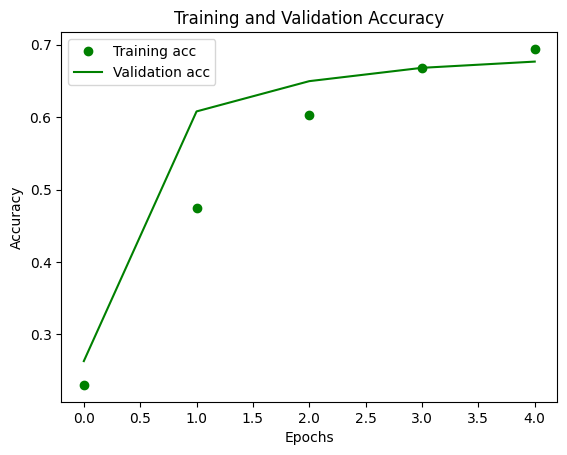

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the column names as keys and the values as lists
data = {'Training acc': [0.2302, 0.4743, 0.6026, 0.6673, 0.6942],
        'Validation acc': [0.2631, 0.6079, 0.6497, 0.6681, 0.6767]}

# Create the DataFrame from the dictionary
df = pd.DataFrame(data)

# Plot the graph
plt.plot(df['Training acc'], 'go', label='Training acc')
plt.plot(df['Validation acc'], 'g', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
